In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot(input_data,save):
    lon=input_data[input_data.dims[1]].data
    lat=input_data[input_data.dims[0]].data
    #axs=axs.flatten()
    L2=[-.6,-.5,-.4,-.3,-.2,-.1,-.05,0,.05,.1,.2,.3,.4,.5,.6]
    fig, axs = plt.subplots(nrows=1,ncols=1,subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(7,7))
    cs=axs.contourf(lon,lat,input_data,levels=30,transform = ccrs.PlateCarree(),cmap='seismic',extend='both')
    #axs.setextent([78,100,4,25])
    #axs[1].set_title(year,fontsize = 15, weight='bold')
    axs.coastlines()
    
    axs.add_patch(Rectangle((90,10),3,2,linewidth=2,edgecolor='r',facecolor='none'))
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
    gl.top_labels = False
    gl.bottom_labels = True
    gl.right_labels = False
    gl.left_labels = True
    cb_ax=fig.add_axes([0.93,0.2,0.02,0.6])
    cba=fig.colorbar(cs,cax=cb_ax)

    plt.suptitle('title',fontsize = 20,weight='bold')
    plt.savefig(save,dpi=120)
    return

#plot(BoB_LCSBI_low[100],'save.jpg')

In [3]:
def BoB_plot(input_data,title,output):
########## Data ########
    #input_data=input_data.rename({input_data.dims[0]:'time'})
    datasets={}
    for i in range(1995,2019):
        summer_unfiltered=input_data.sel(time=slice(repr(i)+'-06-01',repr(i)+'-08-31')).mean(dim='time')
        datasets[i]=[]
        datasets[i].append(summer_unfiltered)
    lon=input_data.longitude.data
    lat=input_data.latitude.data
########## Info ######
    Summer_enso_info={}
    Summer_enso_info=dict({1993:None,1994:'ME, ONI:0.4',1995:'ML, ONI:-0.2',1996: None,1997:'VSE, ONI:1.6',
                        1998:'SL, ONI:-0.8',1999:'SL, ONI:-1.1',2000:'WL, ONI:-0.6',2001:None,2002:'ME, ONI:0.8',
                        2003:None,2004:'WE, ONI:0.5',2005:'WL, ONI:-0.1',2006:'WE, ONI:0.1',2007:'SL, ONI:-0.5',
                        2008:'WL, ONI:-0.4',2009:'ME, ONI:0.5',2010:'SL, ONI:-1.0',2011:'ML, ONI:-0.5',2012:None,
                        2013:None,2014:'WE, ONI:0.1',2015:'VSE, ONI:1.5',2016:'WL, ONI:-0.4',2017:'WL, ONI:0.1',
                        2018:'WE, ONI:0.1',2019:None,2020:'ML, ONI:-0.4',2021:'ML, ONI:-0.4'})

    Elnino_years=[1994,1997,2002,2004,2006,2009,2014,2015,2018]
    Lanina_years=[1995,1998,1999,2000,2005,2007,2008,2010,2011,2016,2017,2020,2021]
##########  Plotting ###########
    fig, axs = plt.subplots(nrows=5,ncols=5,subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(15,12))
    axs=axs.flatten()
    y_label=set([0,5,10,15,20])
    x_label=set([20,21,22,23,24])
    L1=[-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9]
    L2=[-15,-12.5,-10,-7.5,-5,-2.5,0,2.5,5,7.5,10,12.5,15]
    for i,year in enumerate(datasets):
            data=datasets[year]
            cs=axs[i].contourf(lon,lat,data[0],
                              levels=L1,transform = ccrs.PlateCarree(),
                              cmap='seismic',extend='both')
            axs[i].set_extent([78,100,4,25])
            axs[i].set_title(year,fontsize = 15, weight='bold')
            #axs[i].add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
            axs[i].coastlines()
            if i in y_label:
                gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
                gl.top_labels = False
                gl.bottom_labels = False
                gl.right_labels = False
                #gl.xlines=False
            if i in x_label:
                gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
                gl.top_labels = False
                gl.left_labels = False
                gl.right_labels = False
            if year in Elnino_years:
                axs[i].text(88,23.5, Summer_enso_info[year],color='red', fontsize = 9,weight='bold')
            if year in Lanina_years:
                axs[i].text(88,23.5, Summer_enso_info[year],color='blue', fontsize = 9,weight='bold')

    cb_ax=fig.add_axes([0.93,0.2,0.02,0.6])
    cba=fig.colorbar(cs,cax=cb_ax)
    plt.suptitle(title,fontsize = 30,weight='bold')
    plt.savefig(output,dpi=120)
    
    return 



## Filtering code ------------------

In [4]:
import scipy.signal as signal
def butterworth_lowpass_filter(data, cutoff_time, axis=0):
    cutoff_freq=1/cutoff_time
    nyfreq=cutoff_freq*2
    order=4
    B, A = signal.butter(order, nyfreq, output="ba")
    return signal.filtfilt(B, A, data, axis=0)

def filter_data(data,var):
    data_low = butterworth_lowpass_filter(data, 400)
    data_low=xr.DataArray(data_low,coords={"time": data.time, "latitude": data.latitude,
                              "longitude": data.longitude},name=str(var),
                      dims=["time", "latitude","longitude"])
    return data_low

# BoB Domain figure

In [5]:
etopo=xr.open_mfdataset("/home/NCAOR/supriyog/raw_data/etopo_data/ETOPO2v2c_f4.nc").sel(x=slice(30,120),y=slice(-30,30)).z
etopo

<xarray.DataArray 'z' (y: 1800, x: 2700)>
dask.array<getitem, shape=(1800, 2700), dtype=float32, chunksize=(1800, 2700), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float32 30.02 30.05 30.08 30.12 ... 119.9 119.9 119.9 120.0
  * y        (y) float32 -29.98 -29.95 -29.92 -29.88 ... 29.88 29.92 29.95 29.98
Attributes:
    long_name:     z
    actual_range:  [-10791.   8440.]

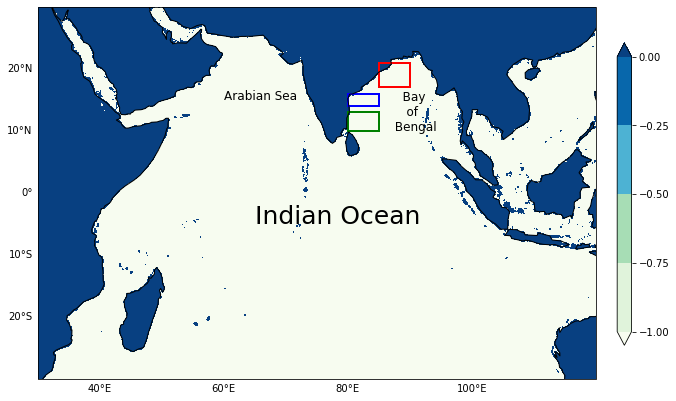

In [6]:
input_data=etopo
lon=input_data.x
lat=input_data.y
#axs=axs.flatten()
L2=np.linspace(-1,0,5)
fig, axs = plt.subplots(nrows=1,ncols=1,subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,7))
cs=axs.contourf(lon,lat,input_data,levels=L2,transform = ccrs.PlateCarree(),cmap='GnBu',extend='both')
#axs.setextent([78,100,4,25])
#axs[1].set_title(year,fontsize = 15, weight='bold')
axs.coastlines()

axs.add_patch(Rectangle((80,10),5,3,linewidth=2,edgecolor='g',facecolor='none'))
axs.add_patch(Rectangle((80,14),5,2,linewidth=2,edgecolor='b',facecolor='none'))
axs.add_patch(Rectangle((85,17),5,4,linewidth=2,edgecolor='r',facecolor='none'))
plt.text(65,-5, 'Indian Ocean', fontsize = 25)
plt.text(87,10, '   Bay\n    of\n Bengal', fontsize = 12)
plt.text(60,15, 'Arabian Sea', fontsize = 12)


gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
cb_ax=fig.add_axes([0.93,0.2,0.02,0.6])
cba=fig.colorbar(cs,cax=cb_ax)

#plt.suptitle('title',fontsize = 20,weight='bold')
plt.savefig('domain_fig.jpg',dpi=120)


# Unfilltered Data Import

In [37]:
path='./datasets/unfiltered/'
BoB_altimeter=xr.open_dataset(path+'BoB_altimeter.nc')
BoB_oscar=xr.open_dataset(path+'BoB_oscar.nc')*100
BoB_LCSCR=xr.open_dataset(path+'BoB_LCSCR.nc')
BoB_LCSBI=xr.open_dataset(path+'BoB_LCSBI.nc')
BoB_LCSEB=xr.open_dataset(path+'BoB_LCSEB.nc')
BoB_LCSWB=xr.open_dataset(path+'BoB_LCSWB.nc')
BoB_LCSEIO=xr.open_dataset(path+'BoB_LCSEIO.nc')

In [38]:
BoB_oscar=BoB_oscar.interp_like(BoB_altimeter)
BoB_altimeter=xr.merge([BoB_oscar,BoB_altimeter])

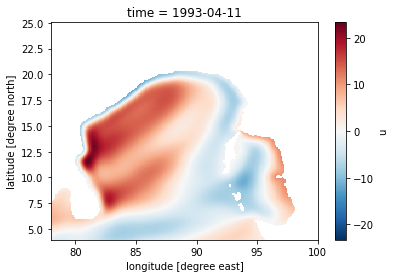

In [9]:
data=BoB_LCSCR.isel(time=100).u
# data=data.where(data<1000)
# data=data.where(data!=0,np.nan)
data.plot()

# Filtered Data Import

In [39]:
path='./datasets/filtered/'
BoB_altimeter_low = xr.open_dataset(path+"BoB_altimeter_low.nc")
BoB_oscar_low=xr.open_dataset(path+'BoB_oscar_low.nc')*100
BoB_LCSCR_low = xr.open_dataset(path+"BoB_LCSCR_low.nc")
BoB_LCSWB_low = xr.open_dataset(path+"BoB_LCSWB_low.nc")
BoB_LCSEB_low = xr.open_dataset(path+"BoB_LCSEB_low.nc")
BoB_LCSBI_low = xr.open_dataset(path+"BoB_LCSBI_low.nc")
BoB_LCSEIO_low = xr.open_dataset(path+"BoB_LCSEIO_low.nc")


In [40]:
BoB_oscar_low=BoB_oscar_low.interp_like(BoB_altimeter_low)
BoB_altimeter_low=xr.merge([BoB_oscar_low,BoB_altimeter_low])

In [639]:
!git push

Everything up-to-date


# Correlation & RMSE

In [ ]:
obs=BoB_altimeter.sel(time=slice('01-01-2000','30-01-2019'))
model=BoB_LCSCR.sel(time=slice('01-01-2000','30-01-2019'))
obs = obs.interp_like(model)

obs_low=BoB_altimeter_low.sel(time=slice('01-01-2000','30-01-2019'))
model_low=BoB_LCSCR_low.sel(time=slice('01-01-2000','30-01-2019'))
obs_low = obs_low.interp_like(model_low)

## Correlation of BoB Altimeter and LCS

In [373]:
corr_altimter_LCSCR=xr.corr(obs.sla,model.sla,dim='time')
corr_U_oscar_LCSCR=xr.corr(obs.u,model.u,dim='time')
corr_V_oscar_LCSCR=xr.corr(obs.v,model.v,dim='time')

## Correlation of BoB Altimeter low and LCSCR low

In [375]:
corr_altimter_LCSCR_low=xr.corr(obs_low.sla_low,model_low.sla_low,dim='time')
corr_U_oscar_LCSCR_low=xr.corr(obs_low.u_low,model_low.u_low,dim='time')
corr_V_oscar_LCSCR_low=xr.corr(obs_low.v_low,model_low.v_low,dim='time')

In [377]:
corr_altimter_LCSCR=xr.corr(obs,model,dim='time')
corr_altimter_LCSCR_low=xr.corr(obs_low.sla_low,model_low.sla_low,dim='time')


TypeError: Only xr.DataArray is supported.Given [<class 'xarray.core.dataset.Dataset'>, <class 'xarray.core.dataset.Dataset'>].

## RMSE

In [15]:
def rmse(obs, model):
    dat=np.sqrt(((obs - model) ** 2).mean('time'))
    return dat

In [376]:
altimeter_rmse=rmse(obs,model)
altimeter_rmse_low=rmse(obs_low,model_low)

In [382]:
altimeter_rmse

<xarray.Dataset>
Dimensions:    (latitude: 211, longitude: 221)
Coordinates:
  * latitude   (latitude) float32 4.0 4.1 4.2 4.3 4.4 ... 24.7 24.8 24.9 25.0
  * longitude  (longitude) float32 78.0 78.1 78.2 78.3 ... 99.7 99.8 99.9 100.0
Data variables:
    u          (latitude, longitude) float64 nan nan 34.96 35.16 ... nan nan nan
    v          (latitude, longitude) float64 nan nan 19.21 19.21 ... nan nan nan
    sla        (latitude, longitude) float64 nan nan 5.397 5.409 ... nan nan nan

## Correlation RMSE Plotm

In [384]:
corr_rmse_data={}
corr_rmse_data={'Correlation between Altimeter & LCSCR':corr_altimter_LCSCR,
                'Correlation between Altimeter & LCSCR Low':corr_altimter_LCSCR_low,
                'BoB_rmse':altimeter_rmse.sla,
                'BoB_rmse_low':altimeter_rmse_low.sla_low
               }

In [393]:
U_corr_rmse_data={}
U_corr_rmse_data={'Correlation between OSCAR & LCSCR':corr_U_oscar_LCSCR,
                'Correlation between OSCAR & LCSCR Low':corr_U_oscar_LCSCR_low,
                'BoB_rmse':altimeter_rmse.u,
                'BoB_rmse_low':altimeter_rmse_low.u_low
               }

V_corr_rmse_data={}
V_corr_rmse_data={'Correlation between OSCAR & LCSCR':corr_V_oscar_LCSCR,
                'Correlation between OSCAR & LCSCR Low':corr_V_oscar_LCSCR_low,
                'BoB_rmse':altimeter_rmse.v,
                'BoB_rmse_low':altimeter_rmse_low.v_low
               }

In [401]:
def corr_rmse_plot(datasets,title,output):
##########  Plotting ###########
    fig, axs = plt.subplots(nrows=2,ncols=2,subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(15,12))
    axs=axs.flatten()
    L1=[-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8]
    L2=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    #datasets=clim_data_making(input_data)
    for i,year in enumerate(datasets):
            data=datasets[year]
            if i in [0,1]:
                cs=axs[i].contourf(data.longitude,data.latitude,data,
                                  levels=L1,transform = ccrs.PlateCarree(),
                                  cmap='RdBu_r',extend='both') #seismic
                cs_ax=fig.add_axes([0.93,0.56,0.02,0.3])
                # cs_ax=fig.add_axes([0.93,0.3,0.02,0.4])
                cba=fig.colorbar(cs,cax=cs_ax)
            if i in [2,3]:
                cs=axs[i].contourf(data.longitude,data.latitude,data,
                                  levels=L2,transform = ccrs.PlateCarree(),
                                  cmap='Reds',extend='both')
                cs_ax=fig.add_axes([0.93,0.15,0.02,0.3])
                
                cba=fig.colorbar(cs,cax=cs_ax)
            
            axs[i].set_extent([78,100,4,25])
            axs[i].set_title(year,fontsize = 15, weight='bold')
            axs[i].coastlines()
            if i in [0,2]:
                gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
                gl.top_labels = False
                gl.bottom_labels = False
                gl.right_labels = False
                #gl.xlines=False
            if i in [2,3]:
                gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
                gl.top_labels = False
                gl.left_labels = False
                gl.right_labels = False
           
    
    plt.suptitle(title,fontsize = 30,weight='bold')
    plt.savefig(output,dpi=120)   
    return 


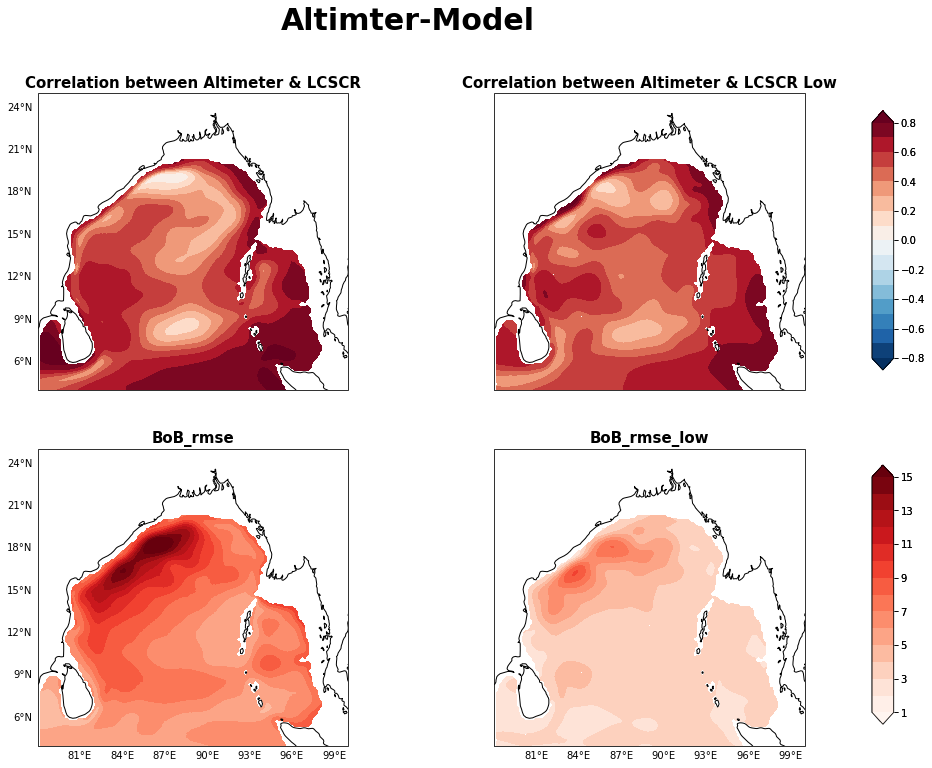

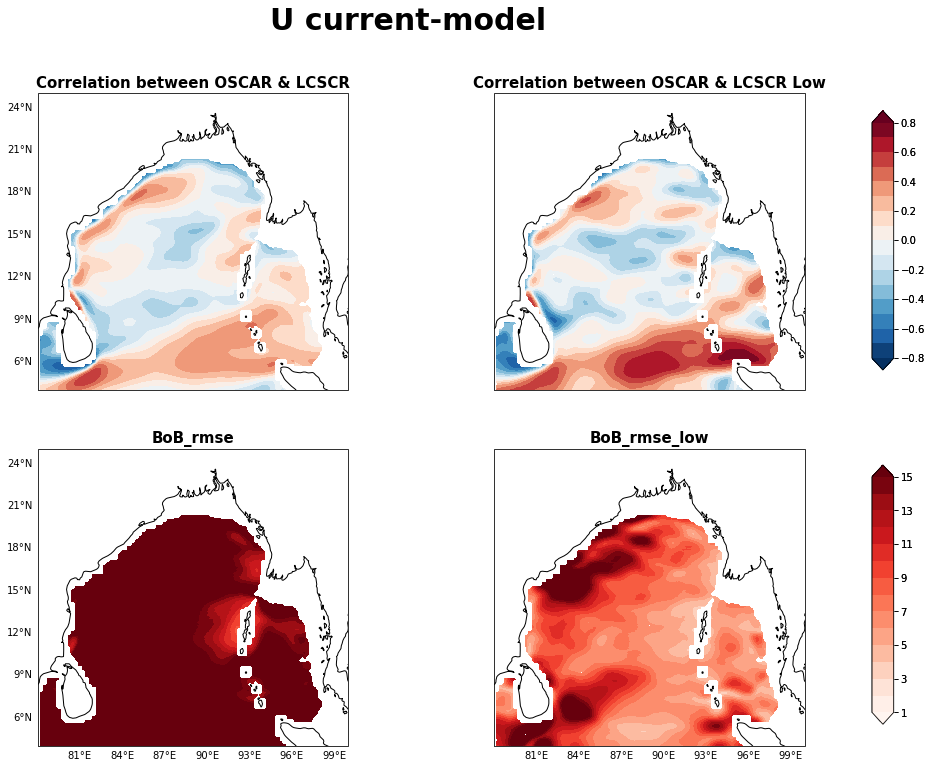

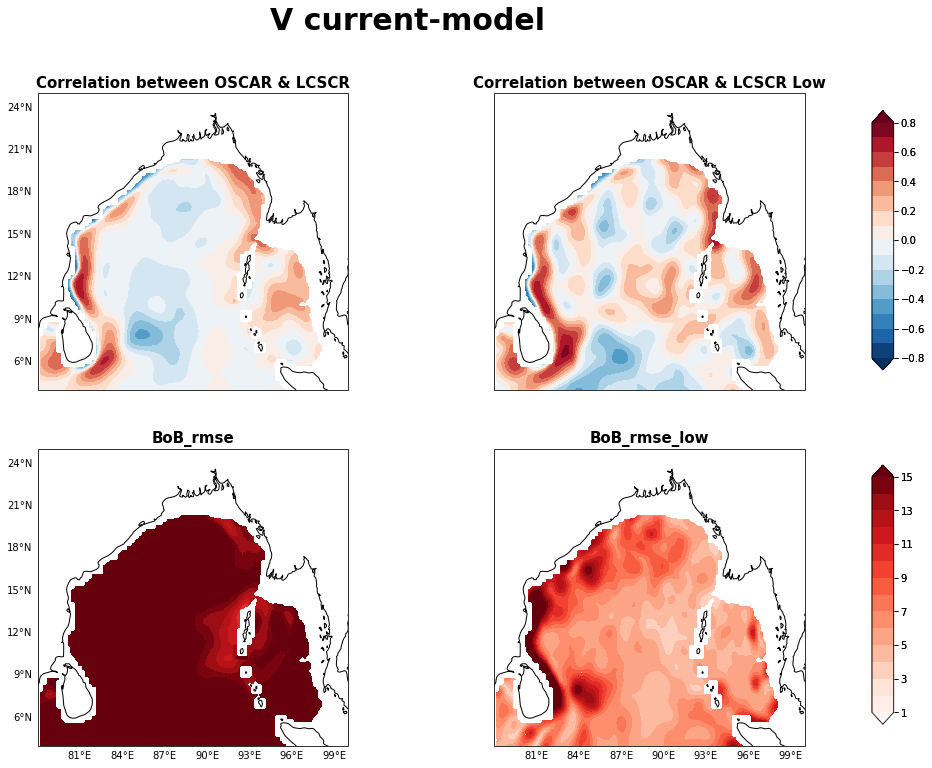

In [402]:
corr_rmse_plot(corr_rmse_data,'Altimter-Model','corr_plot_altimter.jpg')
corr_rmse_plot(U_corr_rmse_data,'U current-model','corr_u_curr.jpg')
corr_rmse_plot(V_corr_rmse_data,'V current-model','corr_v_curr.jpg')

# Decadal change

## Data Preparation

In [19]:
def season_wise_decadal_data(data):
    clim_00_09 =data.sel(time=slice(
        '2000-01-01','2009-12-30')).groupby(
        'time.month').mean(dim='time')

    clim_10_19 =data.sel(time=slice(
        '2010-01-01','2019-12-30')).groupby(
        'time.month').mean(dim='time')

    ### Summer
    summer_00_09_clim=clim_00_09.sel(month=slice(6,8)).mean(dim='month')  
    summer_10_19_clim=clim_10_19.sel(month=slice(6,8)).mean(dim='month') 
    summer_diff=summer_10_19_clim-summer_00_09_clim

    ### Spring
    spring_00_09_clim=clim_00_09.sel(month=slice(3,5)).mean(dim='month')  
    spring_10_19_clim=clim_10_19.sel(month=slice(3,5)).mean(dim='month')   
    spring_diff=spring_10_19_clim-spring_00_09_clim
    
    ### Autumn
    autumn_00_09_clim=clim_00_09.sel(month=slice(9,11)).mean(dim='month')  
    autumn_10_19_clim=clim_10_19.sel(month=slice(9,11)).mean(dim='month')   
    autumn_diff=autumn_10_19_clim-autumn_00_09_clim

    ### Winter
    winter_00_09_clim=clim_00_09.sel(month=[12,1,2]).mean(dim='month')  
    winter_10_19_clim=clim_10_19.sel(month=[12,1,2]).mean(dim='month') 

    winter_diff=winter_10_19_clim-winter_00_09_clim

    datasets={}
    datasets=dict({'spring_00_09_clim':spring_00_09_clim,
               'spring_10_19_clim':spring_10_19_clim,
               'spring_diff':spring_diff,
                'summer_00_09_clim':summer_00_09_clim,
               'summer_10_19_clim':summer_10_19_clim,
               'summer_diff':summer_diff,
                'autumn_00_09_clim':autumn_00_09_clim,
               'autumn_10_19_clim':autumn_10_19_clim,
               'autumn_diff':autumn_diff,
               'winter_00_09_clim':winter_00_09_clim,
               'winter_10_19_clim':winter_10_19_clim,
               'winter_diff':winter_diff,
               'winter_diff':winter_diff})
    return datasets



In [41]:
altimeter_low_decadal_ds=season_wise_decadal_data(BoB_altimeter_low)
LCSCR_low_decadal_ds=season_wise_decadal_data(BoB_LCSCR_low)
LCSWB_low_decadal_ds=season_wise_decadal_data(BoB_LCSWB_low)
LCSEB_low_decadal_ds=season_wise_decadal_data(BoB_LCSEB_low)
LCSEIO_low_decadal_ds=season_wise_decadal_data(BoB_LCSEIO_low)
LCSBI_low_decadal_ds=season_wise_decadal_data(BoB_LCSBI_low)

oscar_low_decadal_ds=season_wise_decadal_data(BoB_oscar_low)



In [21]:
p3=[80,85,10,13]
p2=[80,85,14,16]
p1=[85,90,17,21]

## Model Validation

In [42]:
model_validation_dataset={}
model_validation_dataset=dict({'Altimeter_spring_diff':altimeter_low_decadal_ds['spring_diff'],
              'LCSCR_spring_diff':LCSCR_low_decadal_ds['spring_diff'],
               'Altimeter_spring_00_09_clim':altimeter_low_decadal_ds['spring_00_09_clim'],
               'Altimeter_spring_10_19_clim':altimeter_low_decadal_ds['spring_10_19_clim'],
              'LCSCR_spring_00_09_clim':LCSCR_low_decadal_ds['spring_00_09_clim'],
               'LCSCR_spring_10_19_clim':LCSCR_low_decadal_ds['spring_10_19_clim'],
              
              'Altimeter_summer_diff':altimeter_low_decadal_ds['summer_diff'],
              'LCSCR_summer_diff':LCSCR_low_decadal_ds['summer_diff'],
               'Altimeter_summer_00_09_clim':altimeter_low_decadal_ds['summer_00_09_clim'],
              'Altimeter_summer_10_19_clim':altimeter_low_decadal_ds['summer_10_19_clim'],
              'LCSCR_summer_00_09_clim':LCSCR_low_decadal_ds['summer_00_09_clim'],
               'LCSCR_summer_10_19_clim':LCSCR_low_decadal_ds['summer_10_19_clim'],
               
               'Altimeter_autumn_diff':altimeter_low_decadal_ds['autumn_diff'],
              'LCSCR_autumn_diff':LCSCR_low_decadal_ds['autumn_diff'],
               'Altimeter_autumn_00_09_clim':altimeter_low_decadal_ds['autumn_00_09_clim'],
               'Altimeter_autumn_10_19_clim':altimeter_low_decadal_ds['autumn_10_19_clim'],
              'LCSCR_autumn_00_09_clim':LCSCR_low_decadal_ds['autumn_00_09_clim'],
               'LCSCR_autumn_10_19_clim':LCSCR_low_decadal_ds['autumn_10_19_clim'],
               
               'Altimeter_winter_diff':altimeter_low_decadal_ds['winter_diff'],
              'LCSCR_winter_diff':LCSCR_low_decadal_ds['winter_diff'],
               'Altimeter_winter_00_09_clim':altimeter_low_decadal_ds['winter_00_09_clim'],
               'Altimeter_winter_10_19_clim':altimeter_low_decadal_ds['winter_10_19_clim'],
              'LCSCR_winter_00_09_clim':LCSCR_low_decadal_ds['winter_00_09_clim'],
               'LCSCR_winter_10_19_clim':LCSCR_low_decadal_ds['winter_10_19_clim'],
              })

In [103]:
mv_spring={}
mv_spring=dict({'Altimeter_spring_diff':altimeter_low_decadal_ds['spring_diff'],
              
               'Altimeter_spring_00_09_clim':altimeter_low_decadal_ds['spring_00_09_clim'],
               'Altimeter_spring_10_19_clim':altimeter_low_decadal_ds['spring_10_19_clim'],
              'LCSCR_spring_diff':LCSCR_low_decadal_ds['spring_diff'],
                'LCSCR_spring_00_09_clim':LCSCR_low_decadal_ds['spring_00_09_clim'],
               'LCSCR_spring_10_19_clim':LCSCR_low_decadal_ds['spring_10_19_clim']})
mv_summer={}
mv_summer=dict({'Altimeter_summer_diff':altimeter_low_decadal_ds['summer_diff'],
              
               'Altimeter_summer_00_09_clim':altimeter_low_decadal_ds['summer_00_09_clim'],
              'Altimeter_summer_10_19_clim':altimeter_low_decadal_ds['summer_10_19_clim'],
              'LCSCR_summer_diff':LCSCR_low_decadal_ds['summer_diff'],
                'LCSCR_summer_00_09_clim':LCSCR_low_decadal_ds['summer_00_09_clim'],
               'LCSCR_summer_10_19_clim':LCSCR_low_decadal_ds['summer_10_19_clim']})
mv_autumn={}
mv_autumn=dict({'Altimeter_autumn_diff':altimeter_low_decadal_ds['autumn_diff'],
              
               'Altimeter_autumn_00_09_clim':altimeter_low_decadal_ds['autumn_00_09_clim'],
               'Altimeter_autumn_10_19_clim':altimeter_low_decadal_ds['autumn_10_19_clim'],
              'LCSCR_autumn_diff':LCSCR_low_decadal_ds['autumn_diff'],
                'LCSCR_autumn_00_09_clim':LCSCR_low_decadal_ds['autumn_00_09_clim'],
               'LCSCR_autumn_10_19_clim':LCSCR_low_decadal_ds['autumn_10_19_clim']})

mv_winter={}
mv_winter=dict({'Altimeter_winter_diff':altimeter_low_decadal_ds['winter_diff'],
              
               'Altimeter_winter_00_09_clim':altimeter_low_decadal_ds['winter_00_09_clim'],
               'Altimeter_winter_10_19_clim':altimeter_low_decadal_ds['winter_10_19_clim'],
              'LCSCR_winter_diff':LCSCR_low_decadal_ds['winter_diff'],
                'LCSCR_winter_00_09_clim':LCSCR_low_decadal_ds['winter_00_09_clim'],
               'LCSCR_winter_10_19_clim':LCSCR_low_decadal_ds['winter_10_19_clim']})

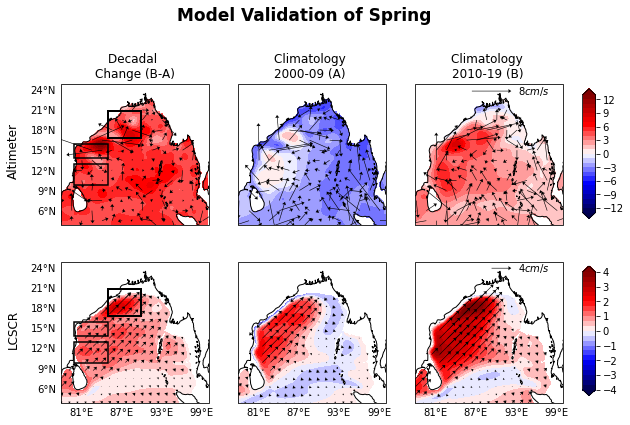

In [590]:

def model_validation_plot(datasets,title,output):
##########  Plotting ###########
    fig, axs = plt.subplots(nrows=2,ncols=3,subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(9,6))
    axs=axs.flatten()
    #L2=[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10]
    # L2=np.linspace(-5,5,11)#[-5,-4,-3,-2,-1,0,1,2,3,4,5]
    x_title=['Decadal \nChange (B-A)',
             'Climatology \n2000-09 (A) ','Climatology \n2010-19 (B) ']
    # #datasets=clim_data_making(input_data)
    for i,year in enumerate(datasets):
            data=datasets[year]

            axs[i].set_extent([78,100,4,25])
            # axs[i].set_title(year,fontsize = 10, weight='bold')
            # if i in [0,2,3, 6,8,9, 12,14,15, 18,20,21] :
            # a=oscar_low_decadal_ds[i]
            axs[i].coastlines()
            if i in [0,1,2]:
                cs1=axs[i].contourf(data.longitude,data.latitude,data.sla_low,
                                  levels=np.linspace(-13,13,27),transform = ccrs.PlateCarree(),
                                  cmap='seismic',extend='both')
                u,v =data.u_low[::6,::6],data.v_low[::6,::6]
                Q=axs[i].quiver(u.longitude,u.latitude,u,v,scale=60,width=.004
                               ,headwidth=7)
            if i in [3,4,5]:
                cs2=axs[i].contourf(data.longitude,data.latitude,data.sla_low,
                                  levels=np.linspace(-4,4,25),transform = ccrs.PlateCarree(),
                                  cmap='seismic',extend='both')
                u,v =data.u_low[::12,::12],data.v_low[::12,::12]
                Q=axs[i].quiver(u.longitude,u.latitude,u,v,scale=30,width=.004
                               ,headwidth=7)#width=.01)
            if i in [0,1,2]:
                axs[i].set_title(x_title[i],fontsize = 12)#, weight='bold')
                # axs[i].text(85,27,x_title[i], size=8,weight='bold',verticalalignment='center', rotation=0)
                
            if i in [0,3]:
                axs[i].add_patch(Rectangle((80,10),5,3,linewidth=1.5,edgecolor='black',facecolor='none'))
                axs[i].add_patch(Rectangle((80,14),5,2,linewidth=1.5,edgecolor='black',facecolor='none'))
                axs[i].add_patch(Rectangle((85,17),5,4,linewidth=2,edgecolor='black',facecolor='none'))

                #axs[i].tick_params(left = True, right = False , labelleft = True , labelbottom = False, bottom = False)
                # axs[i].set_title(year[-22:-12], color='k',weight='bold', rotation='vertical',x=-0.3,y=0.3,fontsize = 15)
                axs[i].text(70,15,year[-22:-12], size=12,verticalalignment='center', rotation=90)#,weight='bold',)
                gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
                gl.top_labels = False
                gl.bottom_labels = False
                gl.right_labels = False
                gl.xlines=False
            if i in [3,4,5]:
                gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
                gl.top_labels = False
                gl.left_labels = False
                gl.right_labels = False
    
    axs[2].quiverkey(Q, 0.82, .855, 8,'$8 cm/s \frac{cm}{s}$'
                            , labelpos='E',coordinates='figure')
    axs[5].quiverkey(Q, 0.82, .445, 4,'$4 cm/s \frac{cm}{s}$'
                            , labelpos='E',coordinates='figure')
    cs1_ax=fig.add_axes([0.93,0.56,0.02,0.3])
    cba=fig.colorbar(cs1,cax=cs1_ax)
    cs2_ax=fig.add_axes([0.93,0.15,0.02,0.3])
    cba=fig.colorbar(cs2,cax=cs2_ax)
    # cb_ax=fig.add_axes([0.15,0.04,0.7,0.015])
    cba=fig.colorbar(cs,orientation="horizontal",cax=cb_ax)
    my_suptitle=plt.suptitle(title,fontsize = 17,weight='bold',y=1.05)
    # plt.savefig(output,dpi=200)
    plt.savefig(output, dpi=200, bbox_inches='tight')
    return 
model_validation_plot(mv_spring, 'Model Validation of Spring', 'Spring_Mod_val.jpg')

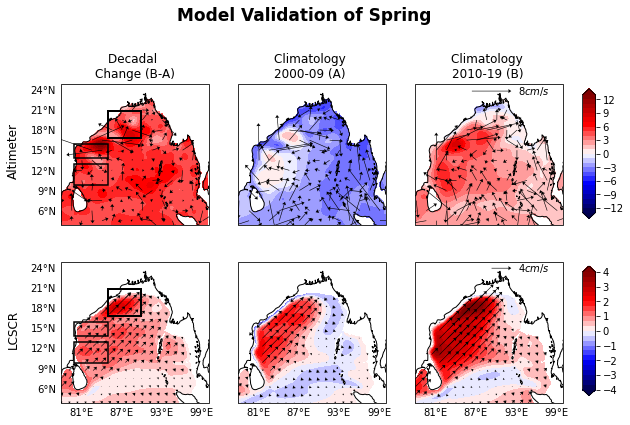

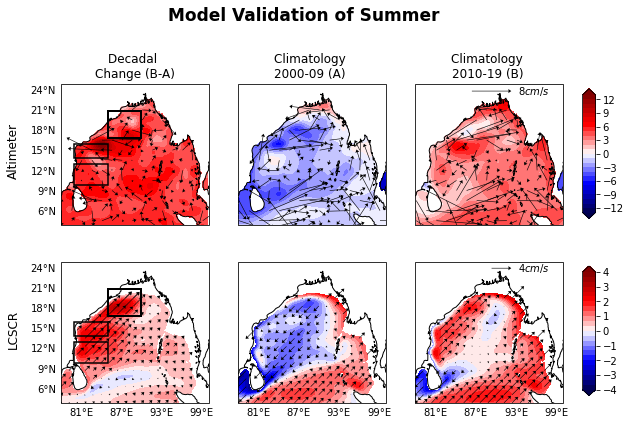

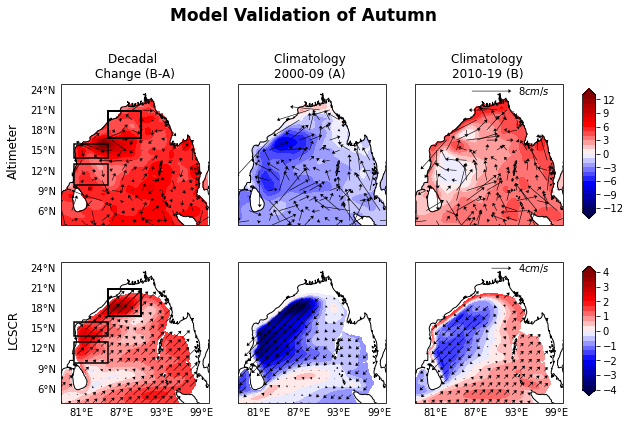

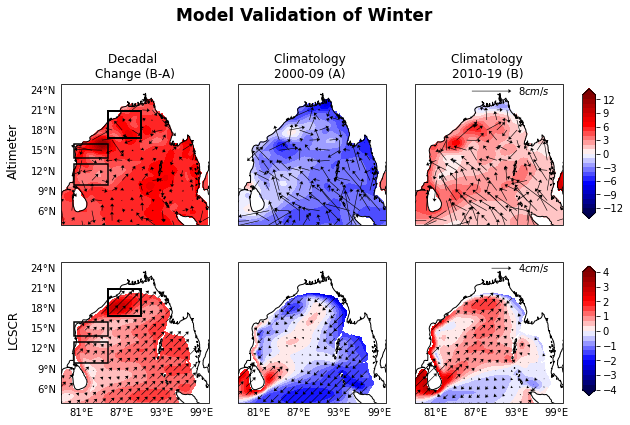

In [591]:
model_validation_plot(mv_spring, 'Model Validation of Spring', 'Spring_Mod_val.jpg')
model_validation_plot(mv_summer, 'Model Validation of Summer', 'Summer_Mod_val.jpg')
model_validation_plot(mv_autumn, 'Model Validation of Autumn', 'Autumn_Mod_val.jpg')
model_validation_plot(mv_winter, 'Model Validation of Winter', 'Winter_Mod_val.jpg')


## Boundary Experiment

In [26]:
def LCSBI_cal(mode):
    lcsbi_data=LCSCR_low_decadal_ds[mode]-(LCSEIO_low_decadal_ds[mode]+
                                          LCSWB_low_decadal_ds[mode]+
                                          LCSEB_low_decadal_ds[mode])
    return lcsbi_data

In [557]:
boundary_expt_dataset={}
boundary_expt_dataset=dict({'LCSCR_spring_diff':LCSCR_low_decadal_ds['spring_diff'],
              'LCSBI_spring_diff':LCSBI_low_decadal_ds['spring_diff'],
              'LCSEIO_spring_diff':LCSEIO_low_decadal_ds['spring_diff'],
                'LCSWB_spring_diff':LCSWB_low_decadal_ds['spring_diff'],
                'LCSEB_spring_diff':LCSEB_low_decadal_ds['spring_diff'],
                
                'LCSCR_summer_diff':LCSCR_low_decadal_ds['summer_diff'],
              'LCSBI_summer_diff':LCSBI_low_decadal_ds['summer_diff'],
              'LCSEIO_summer_diff':LCSEIO_low_decadal_ds['summer_diff'],
                'LCSWB_summer_diff':LCSWB_low_decadal_ds['summer_diff'],
                'LCSEB_summer_diff':LCSEB_low_decadal_ds['summer_diff'],
                            
            'LCSCR_autumn_diff':LCSCR_low_decadal_ds['autumn_diff'],
              'LCSBI_autumn_diff':LCSBI_low_decadal_ds['autumn_diff'],
              'LCSEIO_autumn_diff':LCSEIO_low_decadal_ds['autumn_diff'],
                'LCSWB_autumn_diff':LCSWB_low_decadal_ds['autumn_diff'],
                'LCSEB_autumn_diff':LCSEB_low_decadal_ds['autumn_diff'],
                            
                'LCSCR_winter_diff':LCSCR_low_decadal_ds['winter_diff'],
              'LCSBI_winter_diff':LCSBI_low_decadal_ds['winter_diff'],
              'LCSEIO_winter_diff':LCSEIO_low_decadal_ds['winter_diff'],
                'LCSWB_winter_diff':LCSWB_low_decadal_ds['winter_diff'],
                'LCSEB_winter_diff':LCSEB_low_decadal_ds['winter_diff'],
                            
                           })

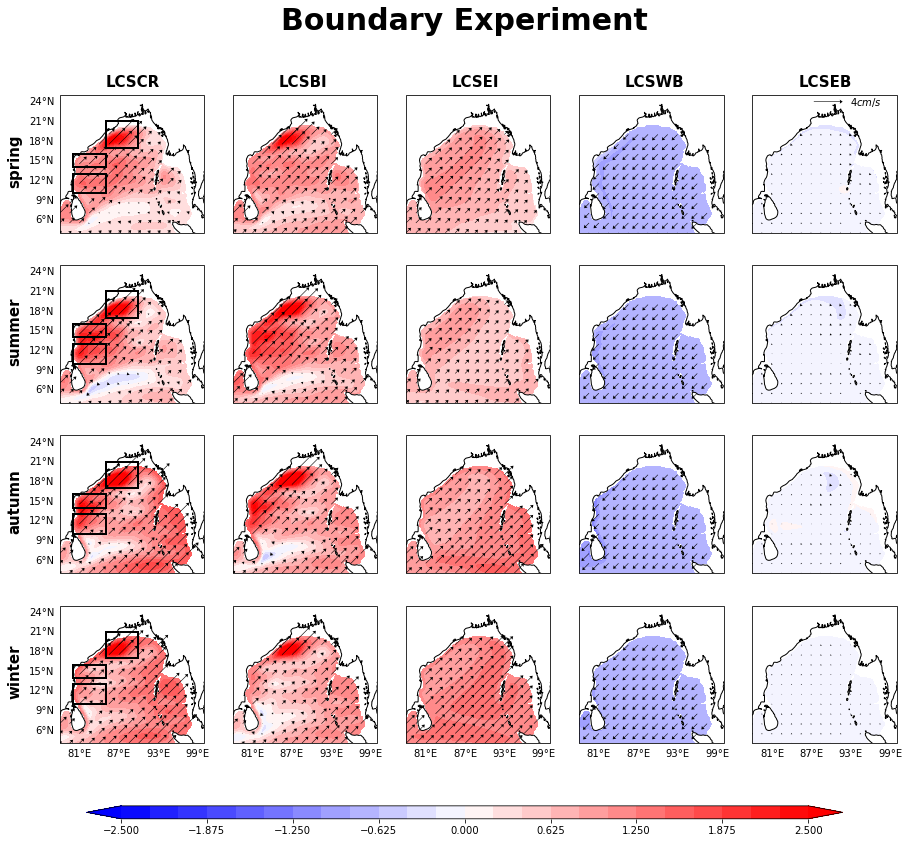

In [592]:
import cartopy as cart
def boundary_expt_plot(datasets,title,output):

##########  Plotting ###########
    fig, axs = plt.subplots(nrows=4,ncols=5,subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(15,12))
    axs=axs.flatten()
    y_label=set([0,5,10,15])
    x_label=set([15,16,17,18,19])
    #L2=[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10]
    # L2=[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,.5,1,1.5,2,2.5,3,3.5]
    #datasets=clim_data_making(input_data)
    for i,year in enumerate(datasets):
            data=datasets[year]
            cs=axs[i].contourf(data.longitude,data.latitude,data.sla_low,
                              levels=np.linspace(-2.5,2.5,25),transform = ccrs.PlateCarree(),
                              cmap='bwr',extend='both') #seismic
            u,v =data.u_low[::15,::15],data.v_low[::15,::15]
            # Q=axs[i].quiver(u.longitude,u.latitude,u,v)
            Q=axs[i].quiver(u.longitude,u.latitude,u,v,scale=20,width=.004
               ,headwidth=7)#width=.01)   
            #axs[i].add_feature(cart.feature.LAND, zorder=100, edgecolor='black')
            axs[i].set_extent([78,100,4,25])
            #axs[i].set_title(year,fontsize = 8, weight='bold')
            axs[i].coastlines()
            if i in [0,5,10,15]:
                axs[i].add_patch(Rectangle((80,10),5,3,linewidth=2,edgecolor='black',facecolor='none'))
                axs[i].add_patch(Rectangle((80,14),5,2,linewidth=2,edgecolor='black',facecolor='none'))
                axs[i].add_patch(Rectangle((85,17),5,4,linewidth=2,edgecolor='black',facecolor='none'))
            if i in [0,1,2,3,4]:
                axs[i].text(85,27,year[0:5], size=15,verticalalignment='center', rotation=0,weight='bold')
            if i in y_label:
                #axs[i].set_title(year[-11:-5], color='k',weight='bold', rotation='vertical',x=-0.3,y=0.3,fontsize = 15)
                axs[i].text(70,15,year[-11:-5], size=15,verticalalignment='center', rotation=90,weight='bold')
                gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
                gl.top_labels = False
                gl.bottom_labels = False
                gl.right_labels = False
                #gl.xlines=False
            if i in x_label:
                gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
                gl.top_labels = False
                gl.left_labels = False
                gl.right_labels = False
    axs[4].quiverkey(Q, 0.85, .87, 4,'$4 cm/s \frac{cm}{s}$'
                            , labelpos='E',coordinates='figure')       
    # cb_ax=fig.add_axes([0.93,0.2,0.02,0.6])
    cb_ax=fig.add_axes([0.15,0.04,0.7,0.015])
    cba=fig.colorbar(cs,cax=cb_ax,orientation="horizontal")
    plt.suptitle(title,fontsize = 30,weight='bold')
    plt.savefig(output,dpi=300)
    return 
boundary_expt_plot(boundary_expt_dataset,'Boundary Experiment','boundary_expt.jpg')

## JPG to PDF

# T test

In [328]:
def t_test_spatial(data):
    clim_00_09 =data.sel(time=slice('1999-01-01','2009-12-30')).groupby(
        'time.dayofyear').mean(dim='time')
    clim_10_19 =data.sel(time=slice('2009-01-01','2019-12-30')).groupby(
        'time.dayofyear').mean(dim='time')

    from scipy.stats import ttest_ind
    stat, p_val = ttest_ind(clim_10_19,clim_00_09)


    df=clim_00_09
    stat=xr.DataArray(stat,coords={"latitude": df.latitude,
                              "longitude": df.longitude},
                      dims=["latitude","longitude"])
    p_val=xr.DataArray(p_val,coords={"latitude": df.latitude,
                              "longitude": df.longitude},
                      dims=["latitude","longitude"])
    return {'stat':stat,'p_val':p_val}


def ttest_data_prep(data):
    clim_00_09 =data.sel(time=slice(
        '1999-01-01','2009-12-30')).groupby(
        'time.dayofyear').mean(dim='time')
    p1_clim_00_09=clim_00_09.sel(latitude=slice(17,21),longitude=slice(85,90)).mean(
        'latitude').mean('longitude')
    p2_clim_00_09=clim_00_09.sel(latitude=slice(14,16),longitude=slice(80,85)).mean(
        'latitude').mean('longitude')
    p3_clim_00_09=clim_00_09.sel(latitude=slice(10,13),longitude=slice(80,85)).mean(
        'latitude').mean('longitude')

    clim_10_19 =data.sel(time=slice(
        '2009-01-01','2019-12-30')).groupby(
        'time.dayofyear').mean(dim='time')
    p1_clim_10_19=clim_10_19.sel(latitude=slice(17,21),longitude=slice(85,90)).mean(
        'latitude').mean('longitude')
    p2_clim_10_19=clim_10_19.sel(latitude=slice(14,16),longitude=slice(80,85)).mean(
        'latitude').mean('longitude')
    p3_clim_10_19=clim_10_19.sel(latitude=slice(10,13),longitude=slice(80,85)).mean(
        'latitude').mean('longitude')
    
    dataset={}
    dataset['P1']=dict({
        'p1_clim_00_09':p1_clim_00_09,
        'p1_clim_10_19':p1_clim_10_19
    })
    
    dataset['P2']=dict({
        'p2_clim_00_09':p2_clim_00_09,
        'p2_clim_10_19':p2_clim_10_19
    })
    
    dataset['P3']=dict({
        'p3_clim_00_09':p3_clim_00_09,
        'p3_clim_10_19':p3_clim_10_19
    })
    return dataset

def ttest_mean(data):
    dataset=ttest_data_prep(data)
    from scipy.stats import ttest_ind
    p1_stat, p1_p_val = ttest_ind(list(dataset['P1'].values())[1],list(dataset['P1'].values())[0])
    p2_stat, p2_p_val = ttest_ind(list(dataset['P2'].values())[1],list(dataset['P2'].values())[0])
    p3_stat, p3_p_val = ttest_ind(list(dataset['P3'].values())[1],list(dataset['P3'].values())[0])
    ttest_res={}
    ttest_res['P1']=dict({'p1_stat':"%.2f."%p1_stat,
                              'p1_p_val':"%.2f."%p1_p_val})
    ttest_res['P2']=dict({'p2_stat':"%.2f."%p2_stat,
                              'p2_p_val':"%.2f."%p2_p_val})
    ttest_res['P3']=dict({'p3_stat':"%.2f."%p3_stat,
                              'p3_p_val':"%.2f."%p3_p_val})
    
    return ttest_res# {'stat':stat,'p_val':p_val}


In [330]:
ttest_altimeter=ttest_mean(BoB_altimeter_low.sla_low)
ttest_LCSCR=ttest_mean(BoB_LCSCR_low.sla_low)
ttest_LCSEIO=ttest_mean(BoB_LCSEIO_low.sla_low)
ttest_LCSBI=ttest_mean(BoB_LCSBI_low.sla_low)
ttest_LCSEB=ttest_mean(BoB_LCSEB_low.sla_low)
ttest_LCSWB=ttest_mean(BoB_LCSWB_low.sla_low)


In [331]:
ttest_final={}
ttest_final['altimeter']=ttest_altimeter
ttest_final['LCSCR']=ttest_LCSCR
ttest_final['LCSEIO']=ttest_LCSEIO
ttest_final['LCSBI']=ttest_LCSBI
ttest_final['LCSWB']=ttest_LCSWB
ttest_final['LCSEB']=ttest_LCSEB



In [332]:
ttest_final=pd.DataFrame(ttest_final).T
ttest_final

,P1,P2,P3
altimeter,"{'p1_stat': '132.90.', 'p1_p_val': '0.00.'}","{'p2_stat': '87.96.', 'p2_p_val': '0.00.'}","{'p3_stat': '36.98.', 'p3_p_val': '0.00.'}"
LCSCR,"{'p1_stat': '13.24.', 'p1_p_val': '0.00.'}","{'p2_stat': '9.90.', 'p2_p_val': '0.00.'}","{'p3_stat': '8.67.', 'p3_p_val': '0.00.'}"
LCSEIO,"{'p1_stat': '43.72.', 'p1_p_val': '0.00.'}","{'p2_stat': '50.37.', 'p2_p_val': '0.00.'}","{'p3_stat': '37.10.', 'p3_p_val': '0.00.'}"
LCSBI,"{'p1_stat': '16.24.', 'p1_p_val': '0.00.'}","{'p2_stat': '12.32.', 'p2_p_val': '0.00.'}","{'p3_stat': '12.72.', 'p3_p_val': '0.00.'}"
LCSWB,"{'p1_stat': '-572.29.', 'p1_p_val': '0.00.'}","{'p2_stat': '-58.24.', 'p2_p_val': '0.00.'}","{'p3_stat': '-58.90.', 'p3_p_val': '0.00.'}"
LCSEB,"{'p1_stat': '-9.47.', 'p1_p_val': '0.00.'}","{'p2_stat': '-12.34.', 'p2_p_val': '0.00.'}","{'p3_stat': '-11.34.', 'p3_p_val': '0.00.'}"


## Altimeter

In [333]:
altimeter_low_ttest=ttest_mean(BoB_altimeter_low.sla_low)
altimeter_low_ttest

{'P1': {'p1_stat': '132.90.', 'p1_p_val': '0.00.'},
 'P2': {'p2_stat': '87.96.', 'p2_p_val': '0.00.'},
 'P3': {'p3_stat': '36.98.', 'p3_p_val': '0.00.'}}

In [334]:
altimeter_low_ttest

{'P1': {'p1_stat': '132.90.', 'p1_p_val': '0.00.'},
 'P2': {'p2_stat': '87.96.', 'p2_p_val': '0.00.'},
 'P3': {'p3_stat': '36.98.', 'p3_p_val': '0.00.'}}

## LCS model

In [339]:
lcs_low_ttest=ttest_mean(BoB_LCSCR_low.sla_low)
lcs_low_ttest

{'P1': {'p1_stat': '13.24.', 'p1_p_val': '0.00.'},
 'P2': {'p2_stat': '9.90.', 'p2_p_val': '0.00.'},
 'P3': {'p3_stat': '8.67.', 'p3_p_val': '0.00.'}}

In [ ]:
lcs_low_ttest['p_val'].plot()
plt.title('LCS low T test: p value ')
plt.savefig('LCS_low_p_value.jpg',dpi=150)

In [ ]:
print("altimeter_low_ttest for two Clim"+str(altimeter_low_ttest))
print("lcs_low_ttest for two Clim"+str(lcs_low_ttest))


# Point checking 

In [341]:
x1,y1=15,84
x2,y2=17.5,86

80°–85°E/10°–13°N, 80°–85°E/14°–16°N and 85°–90°E/17°–21°N

SyntaxError: invalid decimal literal (3476576412.py, line 4)

In [342]:
#80°–85°E/10°–13°N, 80°–85°E/14°–16°N and 85°–90°E/17°–21°N
p1

[85, 90, 17, 21]

In [628]:
p3=[80,85,10,13]
p2=[80,85,14,16]
p1=[85,90,17,21]
season=['spring','summer','autumn','winter']
ds=['altimeter_low_decadal_ds','LCSCR_low_decadal_ds',
    'LCSBI_low_decadal_ds','LCSEIO_low_decadal_ds',
    'LCSWB_low_decadal_ds','LCSEB_low_decadal_ds',
   ]
ds_1=['_diff','_00_09_clim',"_10_19_clim"]
points=['p1','p2','p3']
hist_dataset={}
for n_3,i_3 in enumerate(points):
    hist_dataset[i_3]={}
    for n_2,i_2 in enumerate(season):
        hist_dataset[i_3][i_2]={}
        for n_1,i_1 in enumerate(ds_1[1:3]):
            for n,i in enumerate(ds):
                if i in ['altimeter_low_decadal_ds','LCSCR_low_decadal_ds']:
                    name=eval(i)[i_2+i_1]
                    point=name.sel(latitude=slice(eval(i_3)[2],eval(i_3)[3]),longitude=slice(eval(i_3)[0],eval(i_3)[1])).mean(dim='latitude').mean(dim='longitude').sla_low
                    data_name=i[:10]+i_1[1:6]
                    # print(point)
                    hist_dataset[i_3][i_2][data_name]=float("{:.2f}".format(eval(str(point.values))))
        for n_1,i_1 in enumerate(ds_1[0:1]):
            for n,i in enumerate(ds):
                name=eval(i)[i_2+i_1]
                point=name.sel(latitude=slice(eval(i_3)[2],eval(i_3)[3]),longitude=slice(eval(i_3)[0],eval(i_3)[1])).mean(dim='latitude').mean(dim='longitude').sla_low
                data_name=i[:10]+i_1[1:6]
                hist_dataset[i_3][i_2][data_name]=float("{:.2f}".format(eval(str(point.values))))
                
point1=pd.DataFrame(hist_dataset['p1']).T
point2=pd.DataFrame(hist_dataset['p2']).T
point3=pd.DataFrame(hist_dataset['p3']).T


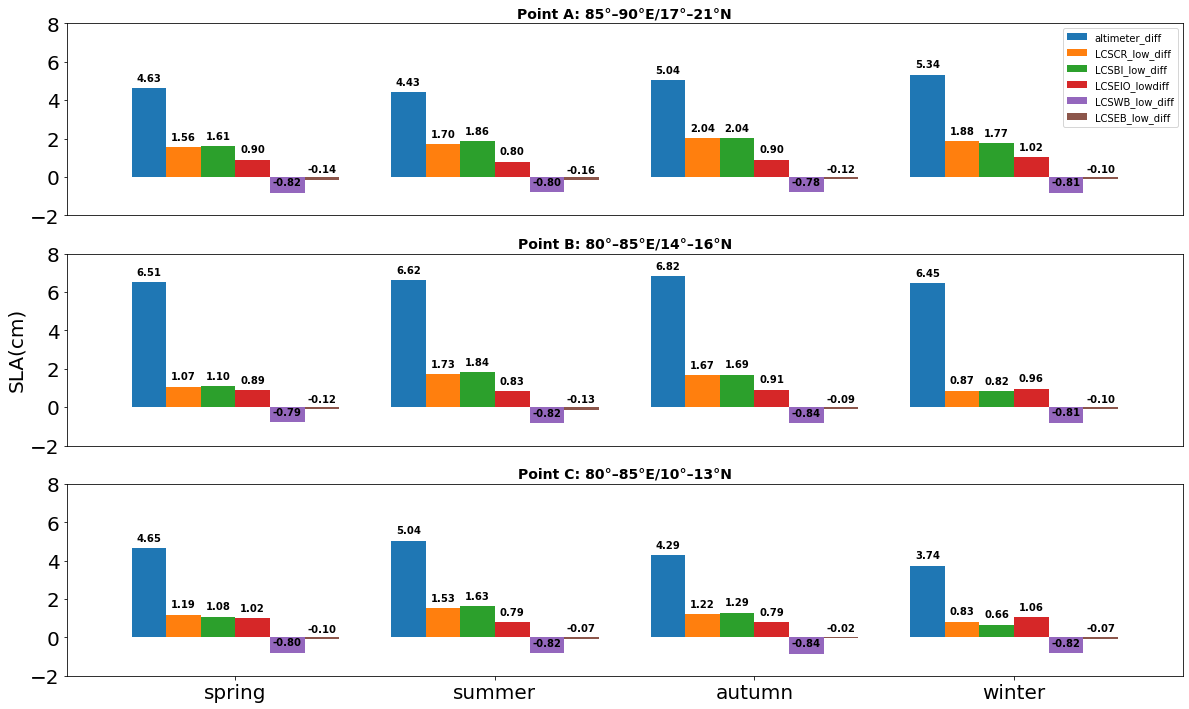

In [637]:
points=[point1.iloc[:,4:],point2.iloc[:,4:],point3.iloc[:,4:]]
titles=['Point A: 85°–90°E/17°–21°N','Point B: 80°–85°E/14°–16°N','Point C: 80°–85°E/10°–13°N',]
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(20,12))


for i,j in enumerate(points):
    j.plot(ax=axes[i],kind='bar',width=.8,rot=0,ylim=(-2,8)
           ,fontsize=20)
    
    if i in [1,2]:
        axes[i].get_legend().remove()
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].set_title(titles[i],fontsize = 14, fontweight ='bold')
    #axes[i].xlabel( fontsize=18)
    for p in axes[i].patches:
        #axes[0].annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()))
        axes[i].annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', xytext=(0, 10),fontweight ='bold', textcoords='offset points')
# plt.xlabel('xlabel', fontsize=18)
axes[1].set_ylabel("SLA(cm)",fontsize = 20)#,fontweight ='bold') #fontweight ='bold')
axes[2].axes.get_xaxis().set_visible(True)
    

plt.savefig('point_comparison.jpg',dpi=150)

## Values of Point A, B, C Table

In [ ]:
print("Point A: 85°–90°E/17°–21°N")
point1

In [ ]:
print("Point B: 80°–85°E/14°–16°N")
point2

In [ ]:
print("Point C: 80°–85°E/10°–13°N")
point3

In [ ]:
LCSCR_low_decadal_ds['spring_00_09_clim']

In [ ]:
BoB_altimeter